# Matlab & GPU
This example notebook requires the kernel "Matlab / GPU" to be used on a GPU node<br>
The initial command in a matlab notebook can take up to a minute to complete.<br/>
This is due to matlab communicating with the LU license server.

Additionally, if using a system with a newer CUDA version (like the A100 presently) Matlab will need to first need to recompile GPU libraries. See [this documentation](https://se.mathworks.com/help/parallel-computing/parallel.gpu.enablecudaforwardcompatibility.html) for more.

## Mandel GPU

In [1]:
% ------ just small trivial op --------
t = tic();
tg = gpuArray.linspace(0,10,10);
naiveGPUTime = toc( t );
disp( sprintf( 'gpuDeviceCount: %d, %1.3f secs (naive GPU)', gpuDeviceCount(), naiveGPUTime ) )

gpuDeviceCount: 1, 18.709 secs (naive GPU)


In [2]:
% ----- here we really start -----------
maxIterations = 500;
gridSize = 1000;
xlim = [-0.748766713922161, -0.748766707771757];
ylim = [ 0.123640844894862,  0.123640851045266];

% Setup
t = tic();
x = gpuArray.linspace( xlim(1), xlim(2), gridSize );
y = gpuArray.linspace( ylim(1), ylim(2), gridSize );
[xGrid,yGrid] = meshgrid( x, y );
z0 = complex( xGrid, yGrid );
count = ones( size(z0), 'gpuArray' );

% Calculate
z = z0;
for n = 0:maxIterations
    z = z.*z + z0;
    inside = abs( z )<=2;
    count = count + inside;
end
count = log( count );

count = gather( count ); % Fetch the data back from the GPU
naiveGPUTime = toc( t );

disp( sprintf( 'gridSize: %d, maxIterations: %d, %1.3f secs (naive GPU)',  gridSize, maxIterations, naiveGPUTime) )

gridSize: 1000, maxIterations: 500, 0.350 secs (naive GPU)


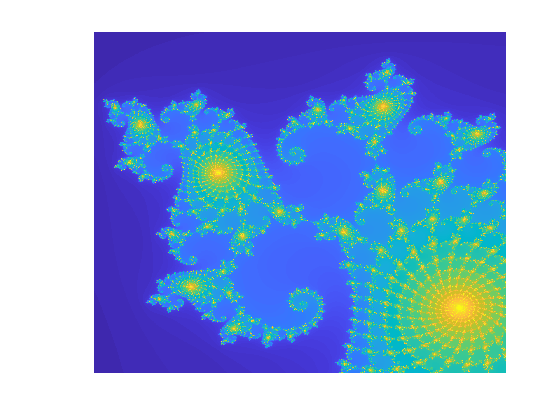

In [3]:
warning('off', 'MATLAB:hg:AutoSoftwareOpenGL');
imagesc( x, y, count )
axis off

## Sparse GPU

In [4]:
% test MATLAB sparse
nbin = 10000; % 10k
npix = 4000000; % 4M

j = randi([1,npix],1,npix);
i = randi([1,nbin],1,npix); % random distribution of pixels into bins
v = rand(size(j));

% matrix
S = sparse(i,j,v,nbin,npix);

% data
nimg = 100;
% array of nimages with npixels
img = repmat((1:nimg),npix,1).*repmat((1:npix).',1,nimg)/10.;

% move to GPU
S_d = gpuArray(S);
img_d = gpuArray(img);

t = tic();

% integrate
bin_d = S_d*img_d;
bin1_d = bin_d(1,1);

bin1 = gather( bin1_d ); % try to comment and uncomment
naiveGPUTime = toc(t);

In [5]:
fprintf( 'class(img): %s, class(S): %s\n', class(img), class(S) )

class(img): double, class(S): double


In [6]:
fprintf( '%1.4f secs per %d of %.1f Mpix (naive GPU)\n', naiveGPUTime, nimg, npix/1.e6 )

0.0501 secs per 100 of 4.0 Mpix (naive GPU)


In [7]:
fprintf( '%.f fps (%.1fM), %.1f Mpix/s\n', nimg/naiveGPUTime, npix/1.e6, npix*nimg/naiveGPUTime/1.e6 )

1997 fps (4.0M), 7987.2 Mpix/s
